## Import all the needed packages

In [1]:
%matplotlib inline

# DataFrame
import pandas as pd

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

from datetime import datetime

import matplotlib.pyplot as plt

# isnan()
import math

# plot
import numpy as np
import matplotlib.pyplot as plt

## Create the local raw_data_pool

In [2]:
raw_data_pool = {}

def make_sure(src_site, dest_site):
    if src_site not in raw_data_pool:
        raw_data_pool[src_site] = {}
    if dest_site not in raw_data_pool[src_site]:
        raw_data_pool[src_site][dest_site] = pd.DataFrame()

def put_data(src_site, dest_site, timestamp_epoch, column_type, value):
    make_sure(src_site, dest_site)
    raw_data_pool[src_site][dest_site].set_value(timestamp_epoch, column_type, value)

## Create the elasticsearch connection

In [3]:
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'])
my_index = "network_weather_2-*"
my_query = {}
my_timeout = 600

In [4]:
# my_query = \
# {
#   "size": 100,
#   "sort": [
#     {
#       "timestamp": {
#         "order": "desc",
#         "unmapped_type": "boolean"
#       }
#     }
#   ],
#   "query": {
#     "filtered": {
#       "query": {
#         "query_string": {
#           "analyze_wildcard": True,
#           "lowercase_expanded_terms": False,
#           "query": "*"
#         }
#       },
#       "filter": {
#         "bool": {
#           "must": [
#             {
#               "query": {
#                 "match": {
#                   "srcSite": {
#                     "query": "Australia-ATLAS",
#                     "type": "phrase"
#                   }
#                 }
#               }
#             },
#             {
#               "query": {
#                 "match": {
#                   "destSite": {
#                     "query": "SFU-LCG2",
#                     "type": "phrase"
#                   }
#                 }
#               }
#             },
#             {
#               "range": {
#                 "timestamp": {
#                   "gte": 1454306400000,
#                   "lte": 1456812000000,
#                   "format": "epoch_millis"
#                 }
#               }
#             }
#           ],
#           "must_not": []
#         }
#       }
#     }
#   },
#   "fields": [
#     "*",
#     "_source"
#   ],
#   "script_fields": {
#     "throughput [Gbps]": {
#       "script": "doc['throughput'].value/1073741824.0",
#       "lang": "expression"
#     }
#   },
#   "fielddata_fields": [
#     "timestamp"
#   ]
# }

In [5]:
# my_query

In [6]:
# type(my_query)

In [7]:
# my_query["query"]["filtered"]["filter"]

In [8]:
# response = es.search(index=my_index, body=my_query, request_timeout=600)

In [9]:
# response

In [10]:
# def ask_total_hits(query_body)

In [11]:
# def generate_query(src_site, dest_site, start_timestamp, end_timestamp):
#     

In [12]:
# # https://gist.github.com/drorata/146ce50807d16fd4a6aa

# # Initialize the scroll
# page = es.search(
#   index = 'network_weather_2-*',
#   doc_type = 'latency',
#   scroll = '2m',
#   search_type = 'scan',
#   size = 10000,
#   body = my_query)

# sid = page['_scroll_id']
# scroll_size = page['hits']['total']
  
# # Start scrolling
# while (scroll_size > 0):
#     print("Scrolling...")
#     page = es.scroll(scroll_id = sid, scroll = '2m')
#     # Update the scroll ID
#     sid = page['_scroll_id']
#     # Get the number of results that we returned in the last scroll
#     scroll_size = len(page['hits']['hits'])
# #     print(page['hits'])
#     print("scroll size: " + str(scroll_size))
#     # Do something with the obtained page

In [13]:
# my_query = \
# {
    
# }

In [14]:
# scroll = helpers.scan(client=es, query=my_query)
# count = 0

# for res in scroll:
#     count += 1
# #     print(res)
# #     print("===============")

# print(count)

In [15]:
src_site = "Australia-ATLAS"
dest_site = "SFU-LCG2"
# timestamp = { 'gte': 1454306400000, 'lte': 1456812000000, 'format': 'epoch_millis' }
# timestamp = { 'gte': 1454306400000, 'lt': 1456812000000 }
# timestamp = { 'gte': '2016-02-01T00:00:00Z', 'lt': '2016-03-01T00:00:00Z' }
timestamp = { 'gte': '2016-01-01T00:00:00Z', 'lt': '2016-06-01T00:00:00Z' }

my_query = {}
my_query['query'] = {}
my_query['query']['filtered'] = {}
my_query['query']['filtered']['query'] = { "match_all": {} }
my_query['query']['filtered']['filter'] = {}
my_query['query']['filtered']['filter']['bool'] = {}
my_query['query']['filtered']['filter']['bool']['must'] = []
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'srcSite': src_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'term': { 'destSite': dest_site } })
my_query['query']['filtered']['filter']['bool']['must'].append({ 'range': { 'timestamp': timestamp } })
my_query['fielddata_fields'] = [ 'timestamp' ]

my_query

{'fielddata_fields': ['timestamp'],
 'query': {'filtered': {'filter': {'bool': {'must': [{'term': {'srcSite': 'Australia-ATLAS'}},
      {'term': {'destSite': 'SFU-LCG2'}},
      {'range': {'timestamp': {'gte': '2016-01-01T00:00:00Z',
         'lt': '2016-06-01T00:00:00Z'}}}]}},
   'query': {'match_all': {}}}}}

In [16]:
scroll = list(helpers.scan(client=es, query=my_query))
count = 0

for res in scroll:
    count += 1
#     print(res)
#     print("====================")
    column_type = res['_type']
    timestamp_epoch = res['fields']['timestamp'][0]
    if column_type == 'latency':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_median', res['_source']['delay_median'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_mean', res['_source']['delay_mean'])
        put_data(src_site, dest_site, timestamp_epoch, 'delay_sd', res['_source']['delay_sd'])
#         print(res['_source']['delay_median'])
#         print(res['_source']['delay_mean'])
#         print(res['_source']['delay_sd'])
#         print(res['fields']['timestamp'][0])
#         print(res['_source']['timestamp'])
    elif column_type == 'packet_loss_rate':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'packet_loss', res['_source']['packet_loss'])
#         print(res['_source']['packet_loss'])
#         print(res['fields']['timestamp'][0])
#         print(res['_source']['timestamp'])
    elif column_type == 'throughput':
        put_data(src_site, dest_site, timestamp_epoch, 'iso_8601', res['_source']['timestamp'])
        put_data(src_site, dest_site, timestamp_epoch, 'throughput', res['_source']['throughput'])
#         print(res['_source']['throughput'])
#         print(res['fields']['timestamp'][0])
#         print(res['_source']['timestamp'])
    else:
        print("Error: type should be latency, packet_loss_rate, or throughput. ")
    
#     if count >= 111:
#         break;

print(count)

114721


In [17]:
# timestamp = "2016-02-01T07:05:00"
# # datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%fZ")
# a = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")

In [18]:
# type(a)

In [19]:
# put_data("aaa", "bbb", a, "latency", 898.3)

In [20]:
# raw_data_pool['aaa']['bbb']

In [21]:
a = raw_data_pool[src_site][dest_site]

In [22]:
a.count(axis='index')

iso_8601        3219
packet_loss     3177
delay_median    3105
delay_mean      3105
delay_sd        3105
throughput        21
dtype: int64

In [23]:
# a.plot()

In [24]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451612100000,2016-01-01T01:35:00,0.0,84.4,84.447333,0.053786,NaN
1451614200000,2016-01-01T02:10:00,NaN,85.6,85.584200,0.092288,NaN
1451614500000,2016-01-01T02:15:00,0.0,NaN,NaN,NaN,NaN
1451616900000,2016-01-01T02:55:00,0.0,86.7,86.706333,0.050595,NaN
1452388500000,2016-01-10T01:15:00,0.0,81.3,81.277556,0.064778,NaN
1452390600000,2016-01-10T01:50:00,0.0,80.3,80.300167,0.043011,NaN
1452392400000,2016-01-10T02:20:00,0.0,83.0,83.004208,0.153796,NaN
1452394500000,2016-01-10T02:55:00,0.0,84.1,84.077417,0.147530,NaN
1452396600000,2016-01-10T03:30:00,0.0,83.7,83.706333,0.232149,NaN
1452547500000,2016-01-11T21:25:00,0.0,81.8,81.764667,0.052772,NaN


In [25]:
a.sort_index(inplace=True)

In [46]:
a

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451607300000,2016-01-01T00:15:00,0.000000,83.6,83.630125,0.049126,NaN
1451609700000,2016-01-01T00:55:00,0.000000,81.8,81.814667,0.052455,NaN
1451612100000,2016-01-01T01:35:00,0.000000,84.4,84.447333,0.053786,NaN
1451614200000,2016-01-01T02:10:00,NaN,85.6,85.584200,0.092288,NaN
1451614500000,2016-01-01T02:15:00,0.000000,NaN,NaN,NaN,NaN
1451616900000,2016-01-01T02:55:00,0.000000,86.7,86.706333,0.050595,NaN
1451619300000,2016-01-01T03:35:00,0.000000,85.0,85.004500,0.041590,NaN
1451621400000,2016-01-01T04:10:00,0.000000,83.8,83.813500,0.179447,NaN
1451623500000,2016-01-01T04:45:00,0.000000,82.6,82.614083,0.068629,NaN
1451625600000,2016-01-01T05:20:00,0.000000,82.5,84.487467,7.805751,NaN


In [26]:
a.to_pickle("raw_data_1.pkl")

In [27]:
# tp = a.loc[a['throughput'] != NaN]

In [28]:
t = a[a.throughput.notnull()]

In [29]:
t

,iso_8601,packet_loss,delay_median,delay_mean,delay_sd,throughput
1451675090000,2016-01-01T19:04:50,NaN,NaN,NaN,NaN,105920000.0
1451805042000,2016-01-03T07:10:42,NaN,NaN,NaN,NaN,606593000.0
1452076266000,2016-01-06T10:31:06,NaN,NaN,NaN,NaN,625393000.0
1452158122000,2016-01-07T09:15:22,NaN,NaN,NaN,NaN,460065000.0
1452661247000,2016-01-13T05:00:47,NaN,NaN,NaN,NaN,527882000.0
1452753236000,2016-01-14T06:33:56,NaN,NaN,NaN,NaN,308804000.0
1452794779000,2016-01-14T18:06:19,NaN,NaN,NaN,NaN,239490000.0
1453975840000,2016-01-28T10:10:40,NaN,NaN,NaN,NaN,552811000.0
1454047943000,2016-01-29T06:12:23,NaN,NaN,NaN,NaN,167993000.0
1454706290000,2016-02-05T21:04:50,NaN,NaN,NaN,NaN,681488000.0


In [30]:
t.shape

(21, 6)

In [31]:
# print(t.iloc(0))

In [32]:
# tt = t.iloc(0)['index']

In [33]:
dataframe_size = a.shape
dataframe_size
p = pd.DataFrame()
for r in range(dataframe_size[0]):
    if not math.isnan(a.iloc[r]['throughput']):
        if (r != 0) and (r != dataframe_size[0] - 1):
            p = p.append(a.iloc[r-1])
            p = p.append(a.iloc[r])
            p = p.append(a.iloc[r+1])

In [34]:
p

,delay_mean,delay_median,delay_sd,iso_8601,packet_loss,throughput
1451674500000,84.436417,84.4,1.625300,2016-01-01T18:55:00,0.0,NaN
1451675090000,NaN,NaN,NaN,2016-01-01T19:04:50,NaN,105920000.0
1451676600000,83.418900,83.4,0.112425,2016-01-01T19:30:00,0.0,NaN
1451803200000,76.117833,76.1,0.087742,2016-01-03T06:40:00,0.0,NaN
1451805042000,NaN,NaN,NaN,2016-01-03T07:10:42,NaN,606593000.0
1451805600000,83.026250,83.0,0.049016,2016-01-03T07:20:00,0.0,NaN
1452072900000,83.264583,83.0,1.278601,2016-01-06T09:35:00,0.0,NaN
1452076266000,NaN,NaN,NaN,2016-01-06T10:31:06,NaN,625393000.0
1452076800000,83.504767,83.8,0.435217,2016-01-06T10:40:00,0.0,NaN
1452157200000,82.699056,82.4,1.656276,2016-01-07T09:00:00,0.0,NaN


In [35]:
p.shape

(63, 6)

In [36]:
g = pd.DataFrame()

# p.index[0]

row = p.shape[0]
for r in range(row):
    line = p.iloc[r]
    if not math.isnan(line['throughput']):
        # This time has the throughput data
        g.set_value(p.index[r], 'iso_8601', line['iso_8601'])
        g.set_value(p.index[r], 'throughput', line['throughput'])
        
        if not math.isnan(line['delay_median']):
            # This time itself has the needed delay_median data
            g.set_value(p.index[r], 'delay_median', line['delay_median'])
        else:
            if (not math.isnan(p.iloc[r-1]['delay_median'])) and (not math.isnan(p.iloc[r+1]['delay_median'])):
                g.set_value(p.index[r], 'delay_median', ( p.iloc[r-1]['delay_median'] + p.iloc[r+1]['delay_median'] ) / 2)
                # dmdtbm = delay_median_deltaT_before(minutes)
                # dmdtam = delay_median_deltaT_after(minutes)
                g.set_value(p.index[r], 'dmdtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'dmdtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 1")
            
        if not math.isnan(line['packet_loss']):
            # This time itself has the needed packet_loss data
            g.set_value(p.index[r], 'packet_loss', line['packet_loss'])
        else:
            if (not math.isnan(p.iloc[r-1]['packet_loss'])) and (not math.isnan(p.iloc[r+1]['packet_loss'])):
                g.set_value(p.index[r], 'packet_loss', ( p.iloc[r-1]['packet_loss'] + p.iloc[r+1]['packet_loss'] ) / 2)
                # pldtbm = packet_loss_deltaT_before(minutes)
                # pldtam = packet_loss_deltaT_after(minutes)
                g.set_value(p.index[r], 'pldtbm', (p.index[r] - p.index[r-1]) / 1000 / 60) # minutes
                g.set_value(p.index[r], 'pldtam', (p.index[r+1] - p.index[r]) / 1000 / 60) # minutes
            else:
                print("Need work 2")

g

,iso_8601,throughput,delay_median,dmdtbm,dmdtam,packet_loss,pldtbm,pldtam
1451675090000,2016-01-01T19:04:50,105920000.0,83.90,9.833333,25.166667,0.0,9.833333,25.166667
1451805042000,2016-01-03T07:10:42,606593000.0,79.55,30.700000,9.300000,0.0,30.700000,9.300000
1452076266000,2016-01-06T10:31:06,625393000.0,83.40,56.100000,8.900000,0.0,56.100000,8.900000
1452158122000,2016-01-07T09:15:22,460065000.0,82.65,15.366667,19.633333,0.0,15.366667,19.633333
1452661247000,2016-01-13T05:00:47,527882000.0,82.20,60.783333,9.216667,0.0,60.783333,9.216667
1452753236000,2016-01-14T06:33:56,308804000.0,82.70,18.933333,11.066667,0.0,18.933333,11.066667
1452794779000,2016-01-14T18:06:19,239490000.0,83.20,6.316667,28.683333,0.0,6.316667,28.683333
1453975840000,2016-01-28T10:10:40,552811000.0,81.45,0.666667,39.333333,0.0,0.666667,39.333333
1454047943000,2016-01-29T06:12:23,167993000.0,83.20,7.383333,27.616667,0.0,7.383333,27.616667
1454706290000,2016-02-05T21:04:50,681488000.0,88.65,49.833333,30.166667,0.0,49.833333,30.166667


In [37]:
# temp = pd.DataFrame()

# temp.set_value(23, 43, 4)
# temp.set_value(22, 44, 5)

# 5 + temp.iloc[1][43]  # 5 + nan = nan

In [38]:
g.to_pickle('before_drawing_1.pkl')

In [47]:
g = pd.read_pickle('before_drawing_1.pkl')

dm = g.delay_median
tp = g.throughput / 1024 / 1024 / 1024 / 8
pl = g.packet_loss



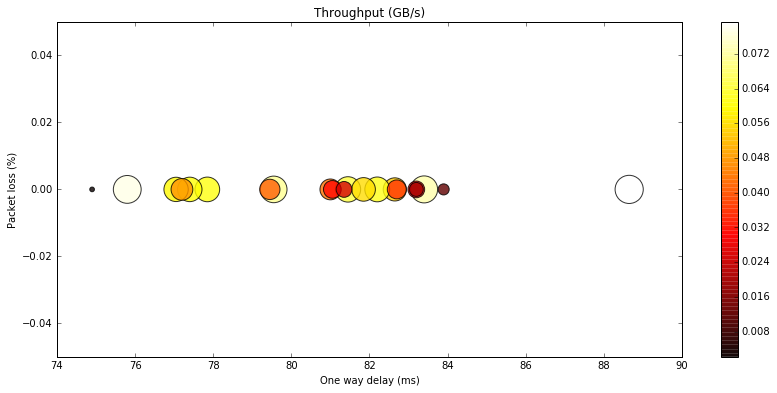

In [48]:
plt.figure(figsize=[14, 6])
plt.scatter(dm, pl, s=tp * 10000, c=tp, alpha=.8, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Packet loss (%)'), plt.title('Throughput (GB/s)')
plt.show()

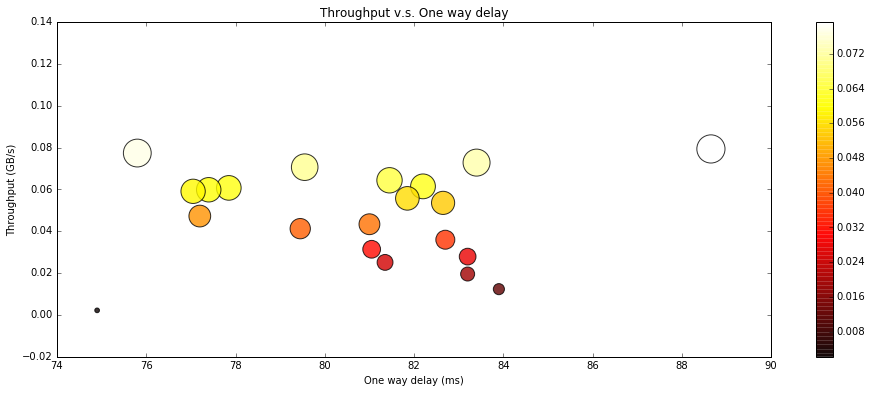

In [41]:
plt.figure(figsize=[16, 6])
plt.scatter(dm, tp, s=tp * 10000, c=tp, alpha=.8, cmap='hot')
plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (GB/s)'), plt.title('Throughput v.s. One way delay')
plt.show()

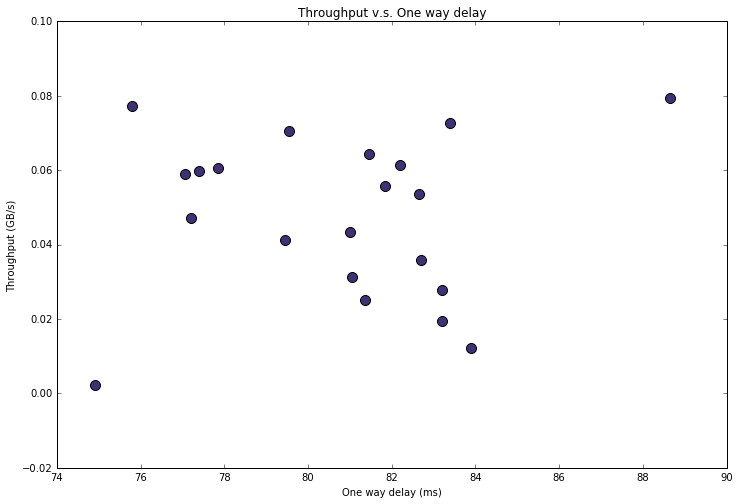

In [45]:
plt.figure(figsize=[12, 8])
plt.scatter(dm, tp, s=100, c='#403075')
# plt.colorbar()
plt.xlabel('One way delay (ms)'), plt.ylabel('Throughput (GB/s)'), plt.title('Throughput v.s. One way delay')
plt.show()

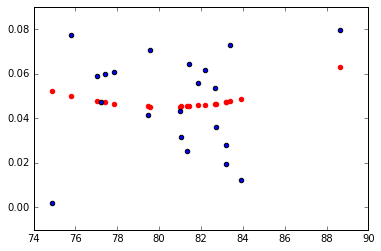

In [106]:
fig, ax = plt.subplots()
fit = np.polyfit(dm, tp, deg=2)
ax.scatter(dm, fit[0] * dm * dm + fit[1] * dm + fit[2], color='red')
ax.scatter(dm, tp)

In [99]:
from sklearn import svm
# X = [[0, 0], [1, 1], [1, 1.2], [0.5, 0.8]]
#y = [1.2, 2.2]
clf = svm.SVR()

# input_dm = dm
# input_pl = pl
# output_tp = tp

# type(input_dm)

# f = clf.fit(X, y)
# print(f)

tp2 = tp * 1024 * 1024 * 1024 * 8

X = []
y = []
# for r in range(21):
#     X.append([dm.iloc[r], pl.iloc[r]])
#     y.append(tp2.iloc[r])

for r in range(21):
    X.append([dm.iloc[r], dm.iloc[r]])
    y.append(tp2.iloc[r])
    
# clf.fit(X, y)

# for r in range(21):
#     X.append([dm.iloc[r]])
#     y.append(tp2.iloc[r])

# clf.fit(X, y)

# X = [[0,1], [1,2], [2,3], [3,4], [4,5]]
# y = [0.55, 1.45, 2.5, 3.4, 4.6]

clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [97]:
X

[[83.900000000000006, 83.900000000000006],
 [79.549999999999997, 79.549999999999997],
 [83.400000000000006, 83.400000000000006],
 [82.650000000000006, 82.650000000000006],
 [82.200000000000003, 82.200000000000003],
 [82.700000000000003, 82.700000000000003],
 [83.200000000000003, 83.200000000000003],
 [81.449999999999989, 81.449999999999989],
 [83.199999999999989, 83.199999999999989],
 [88.650000000000006, 88.650000000000006],
 [81.849999999999994, 81.849999999999994],
 [81.0, 81.0],
 [77.849999999999994, 77.849999999999994],
 [77.400000000000006, 77.400000000000006],
 [77.049999999999997, 77.049999999999997],
 [79.450000000000003, 79.450000000000003],
 [75.799999999999997, 75.799999999999997],
 [81.049999999999997, 81.049999999999997],
 [74.900000000000006, 74.900000000000006],
 [81.349999999999994, 81.349999999999994],
 [77.199999999999989, 77.199999999999989]]

In [98]:
y

[105920000.0,
 606593000.0,
 625393000.0,
 460065000.0,
 527882000.0,
 308804000.0,
 239490000.0,
 552811000.0,
 167993000.0,
 681488000.0,
 478631000.0,
 372403000.0,
 521584000.0,
 513903000.0,
 507509000.0,
 354264000.0,
 664613000.0,
 269639000.0,
 18880500.0,
 215756000.0,
 405914000.0]

In [100]:
clf.predict([[30,31], [80,81], [90,91], [100,101]])

array([  4.60065001e+08,   4.60065000e+08,   4.60065001e+08,
         4.60065001e+08])

In [101]:
from sklearn import svm
X = [[0, 0], [1, 1], [1, 1.2], [0.5, 0.8]]
y = [1.2, 2.2, 3.3, 4.5]
clf = svm.SVR()
f = clf.fit(X, y)
print(f)
type(f)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


sklearn.svm.classes.SVR

In [90]:
clf.predict([[2,4], [5,66]])

array([ 2.24891102,  2.24172001])

In [91]:
X

[[0, 0], [1, 1], [1, 1.2], [0.5, 0.8]]

In [92]:
y

[1.2, 2.2, 3.3, 4.5]